# San Francisco Crime Data
## Kaggle
https://www.kaggle.com/c/sf-crime

https://data.sfgov.org/
***

#### Librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import sklearn
plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')
%matplotlib inline 

#### Datasets

In [2]:
train = pd.read_csv('Datas/Kaggle/SF_Crime/train.csv')
test = pd.read_csv('Datas/Kaggle/SF_Crime/test.csv')
sample = pd.read_csv('Datas/Kaggle/SF_Crime/sampleSubmission.csv')

In [3]:
train.head()

Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

#### Exploration

In [4]:
train.describe()

X              Y
count  878049.000000  878049.000000
mean     -122.422616      37.771020
std         0.030354       0.456893
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416420      37.775421
75%      -122.406959      37.784369
max      -120.500000      90.000000

In [5]:
train['Category'].value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [6]:
train['Resolution'].value_counts()

NONE                                      526790
ARREST, BOOKED                            206403
ARREST, CITED                              77004
LOCATED                                    17101
PSYCHOPATHIC CASE                          14534
UNFOUNDED                                   9585
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3976
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3714
JUVENILE CITED                              3332
PROSECUTED BY OUTSIDE AGENCY                2504
EXCEPTIONAL CLEARANCE                       1530
JUVENILE ADMONISHED                         1455
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
Name: Resolution, dtype: int64

In [7]:
train['DayOfWeek'].value_counts()

Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
Name: DayOfWeek, dtype: int64

In [8]:
train['PdDistrict'].value_counts()

SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
Name: PdDistrict, dtype: int64

In [10]:
#Time conversion
train['year'] = [x[:4] for x in train['Dates']]
train['month'] = [x[5:7] for x in train['Dates']]
train['year_month'] = [x[:7] for x in train['Dates']]
train['day'] = [x[:10] for x in train['Dates']]
train['hour'] = [x[11:13] for x in train['Dates']]
train['full_hour'] = [x[11:16] for x in train['Dates']]

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

train['dayweek'] = [days.index(x) for x in train['DayOfWeek']]

In [10]:
def data_plotting(datas,xlabel,ylabel,title,nticks):
    '''Function to plot from a DataFrame with the counts on a column'''
    data_plot = datas.value_counts().sort_index()
    a = range(len(data_plot))
    xticks = [x for x in a if x%nticks == 0]
    xlabels = [list(data_plot.index)[i] for i in xticks]
    plt.figure(figsize=(15,5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xticks,xlabels,rotation='vertical')
    plt.plot(data_plot)
    plt.title(title)
    plt.show()

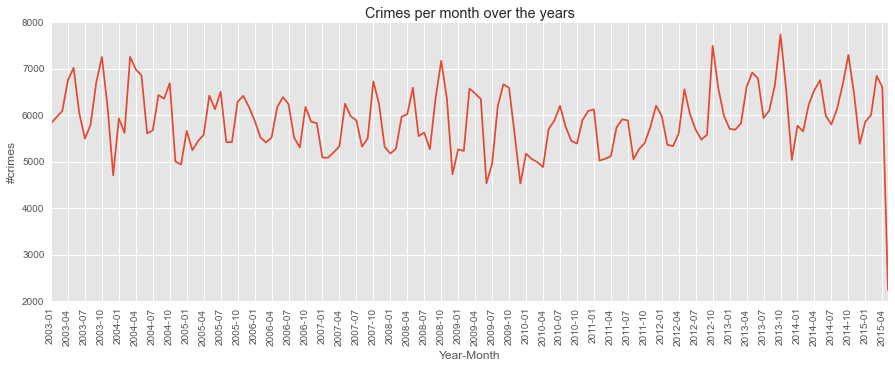

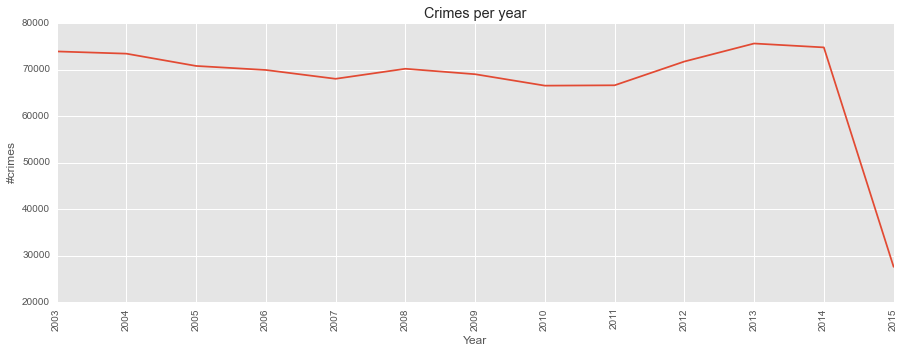

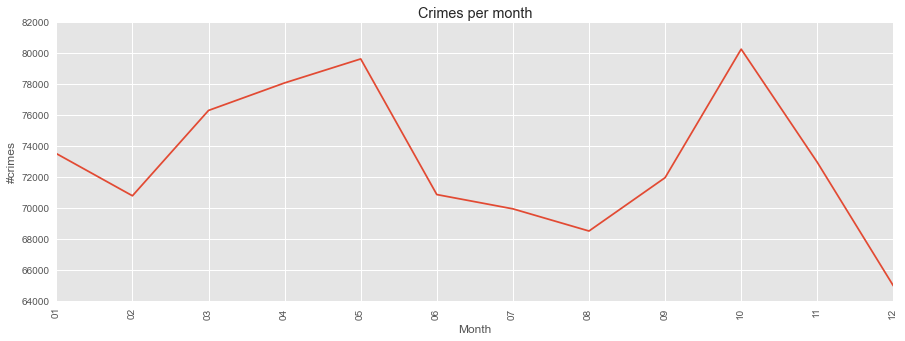

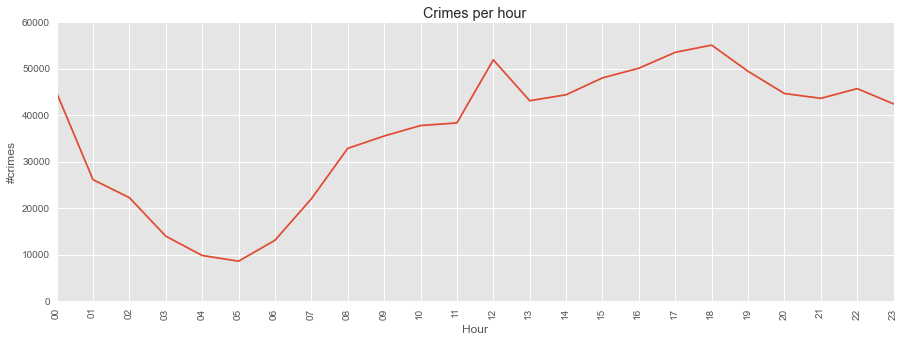

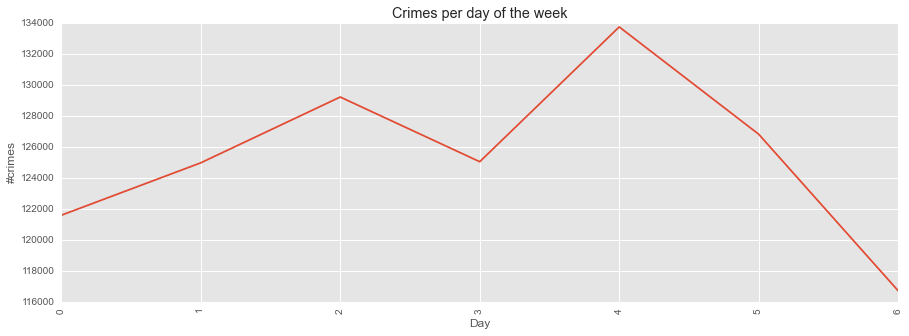

In [11]:
data_plotting(train['year_month'],'Year-Month','#crimes','Crimes per month over the years',3)
data_plotting(train['year'],'Year','#crimes','Crimes per year',1)
data_plotting(train['month'],'Month','#crimes','Crimes per month',1)
data_plotting(train['hour'],'Hour','#crimes','Crimes per hour',1)
data_plotting(train['dayweek'],'Day','#crimes','Crimes per day of the week',1)

In [44]:
mapdata = np.loadtxt("Datas/Kaggle/SF_Crime/sf_map.txt")
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]
train['Xok'] = train[train.X<-121].X
train['Yok'] = train[train.Y<40].Y

trainCopy = train.dropna()

def plot_map(category):
    #Get rid of the bad lat/longs
    if category == 'ALL':
        trainP = trainCopy
    else:
        trainP = trainCopy[trainCopy.Category == category] #Grab the prostitution crimes
    trainP = trainP[:30000]
    
    #Do a larger plot with prostitution only'''
    plt.figure(figsize=(12,20))
    ax = sns.kdeplot(trainP.Xok, trainP.Yok, clip=clipsize, aspect=1/1.3)
    ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=1.3)
    plt.title(category)
    plt.show()
    

In [52]:
categories = ['ALL'] + list(train['Category'].value_counts().index)

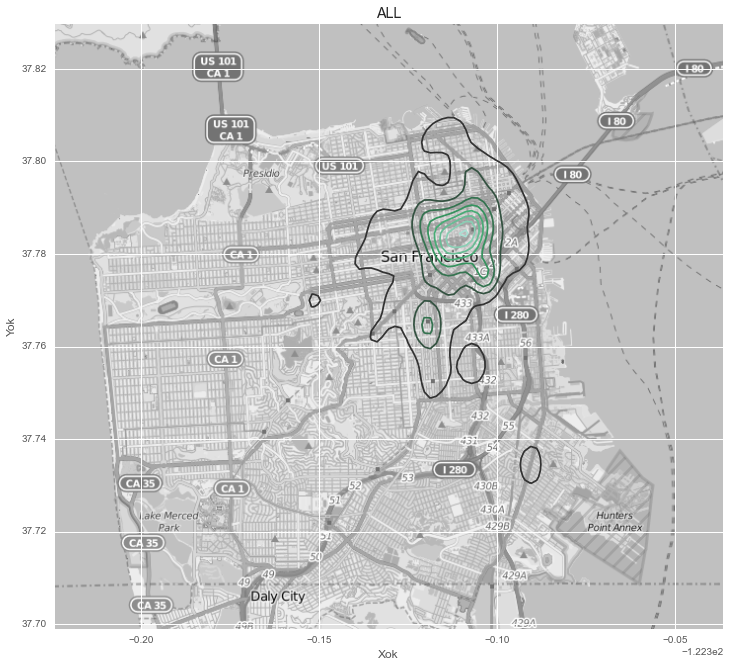

In [26]:
plot_map(categories[0])

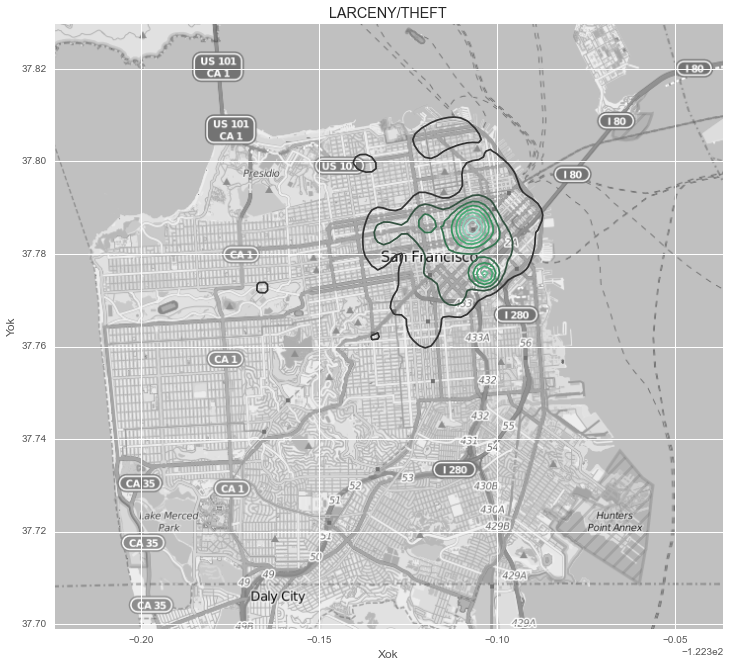

In [29]:
plot_map(categories[1])

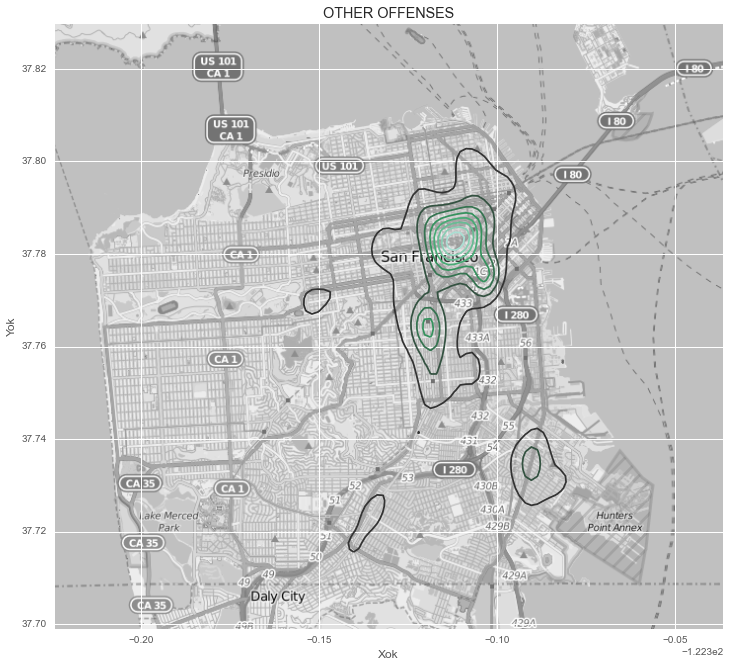

In [30]:
plot_map(categories[2])

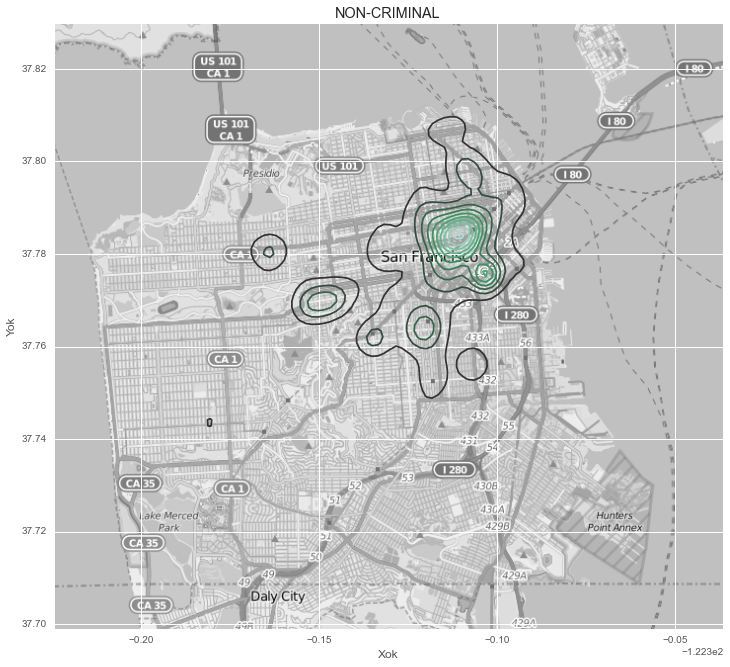

In [31]:
plot_map(categories[3])

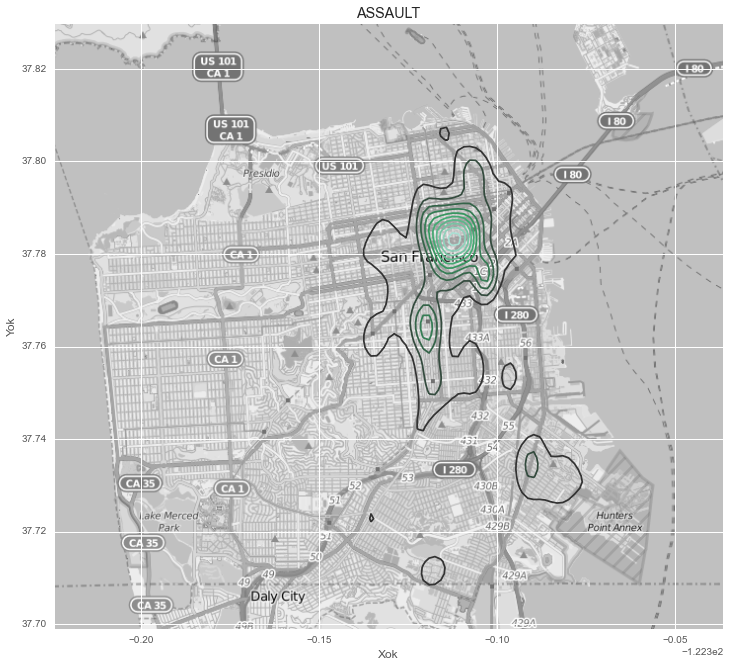

In [32]:
plot_map(categories[4])

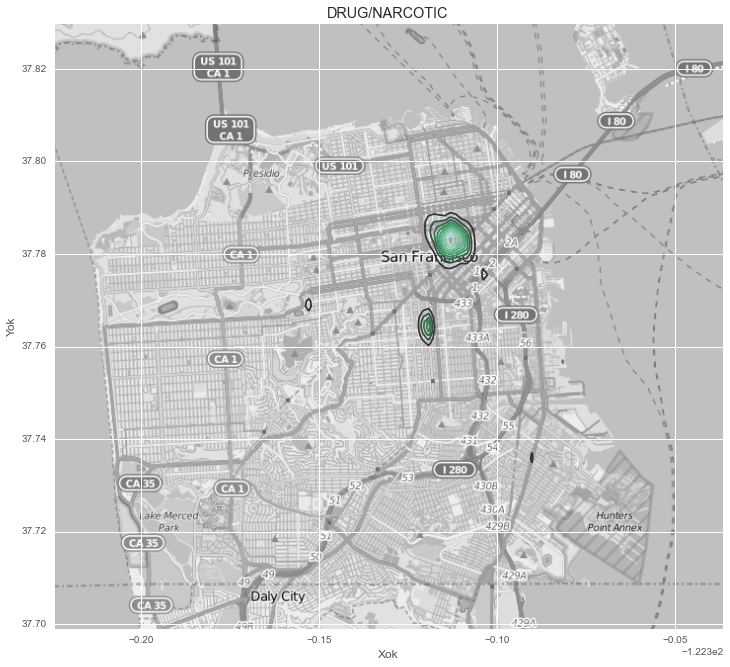

In [33]:
plot_map(categories[5])

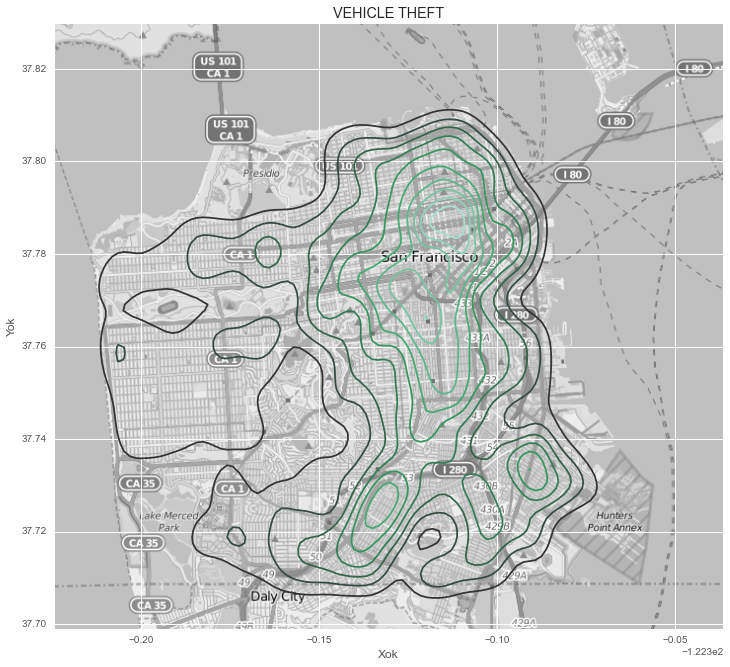

In [34]:
plot_map(categories[6])

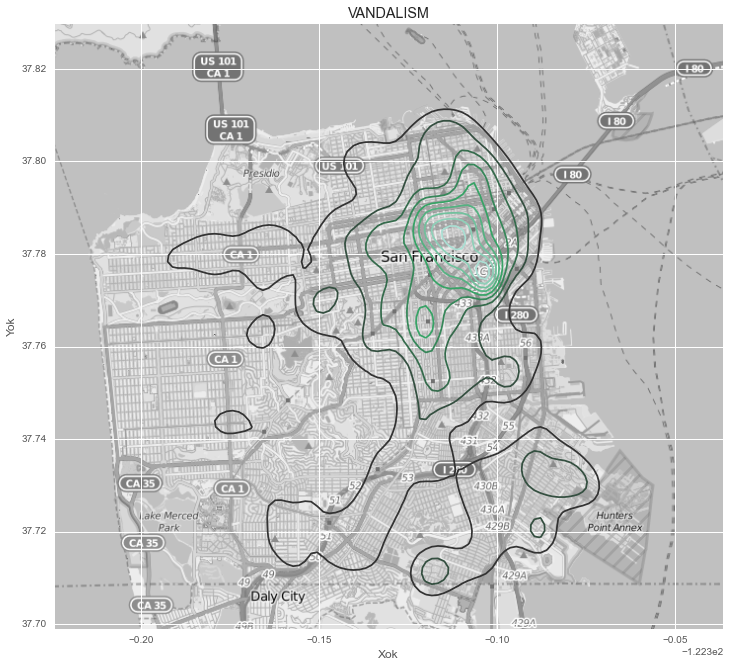

In [35]:
plot_map(categories[7])

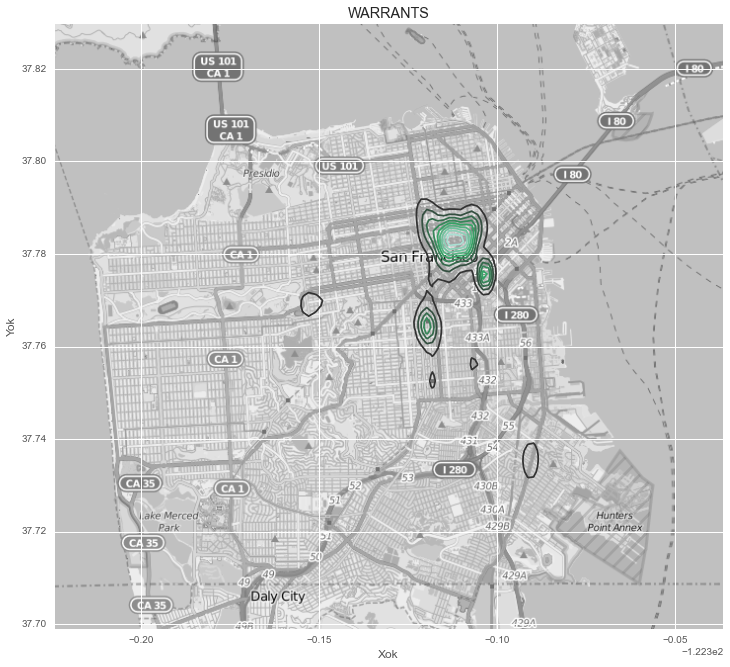

In [36]:
plot_map(categories[8])

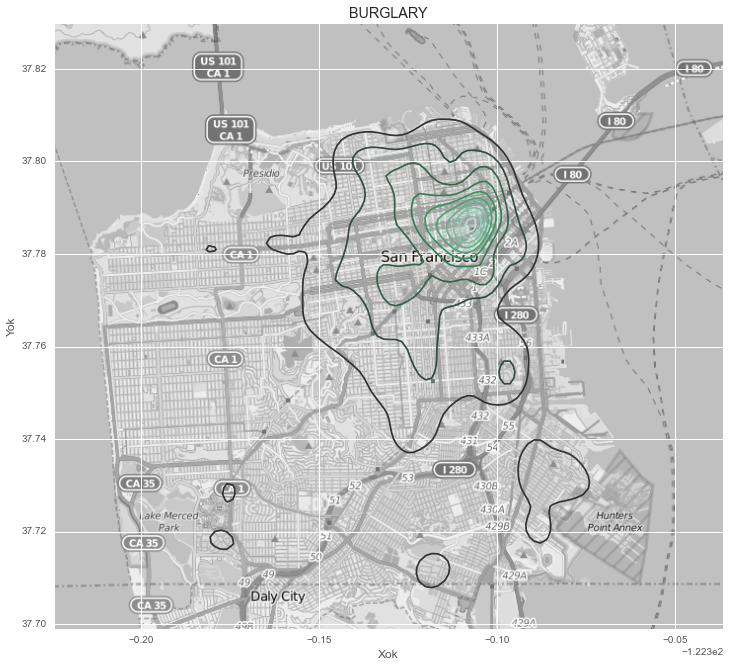

In [45]:
plot_map(categories[9])

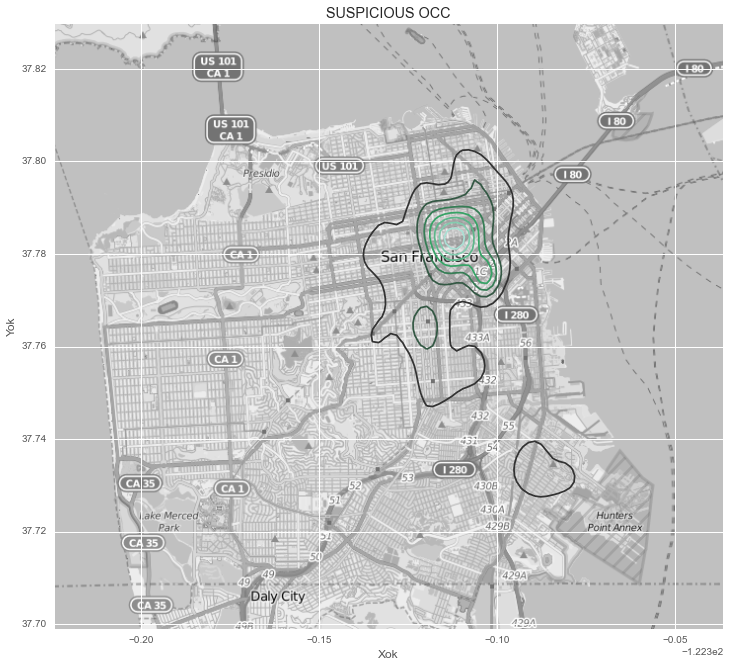

In [46]:
plot_map(categories[10])

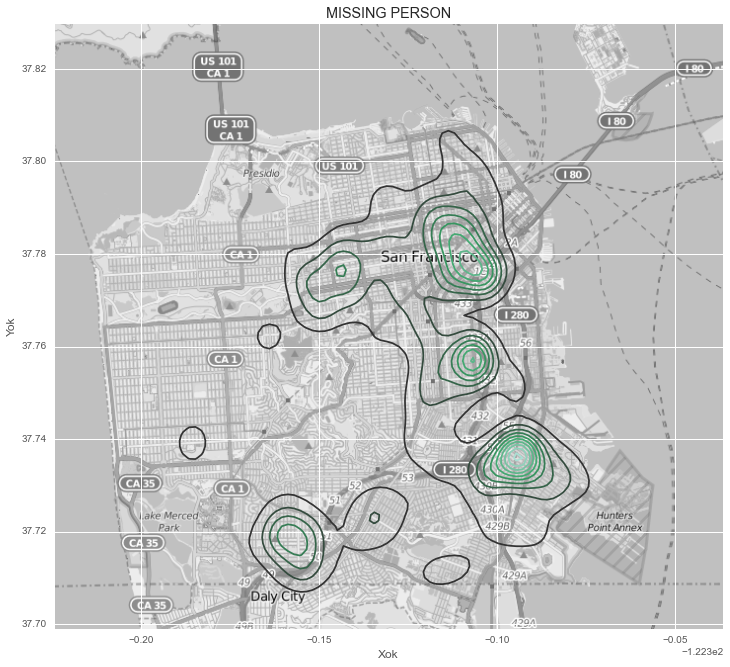

In [47]:
plot_map(categories[11])

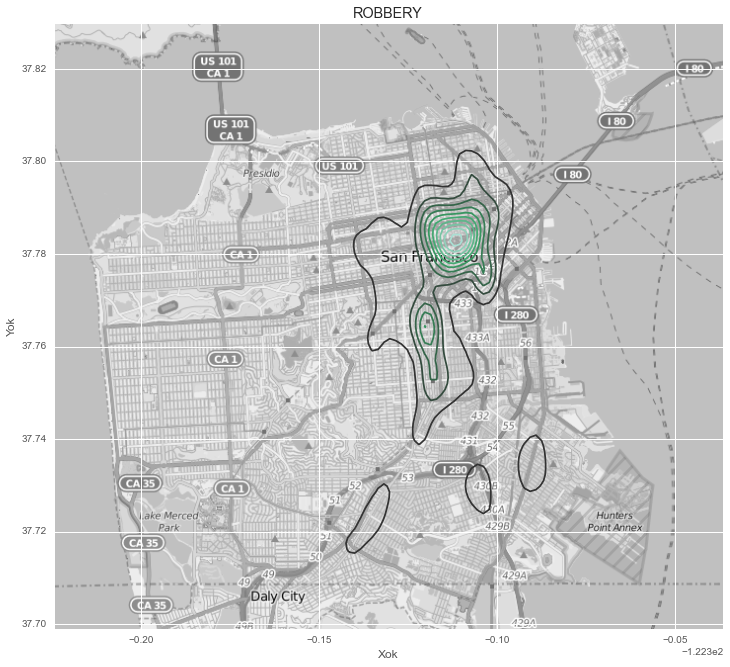

In [48]:
plot_map(categories[12])

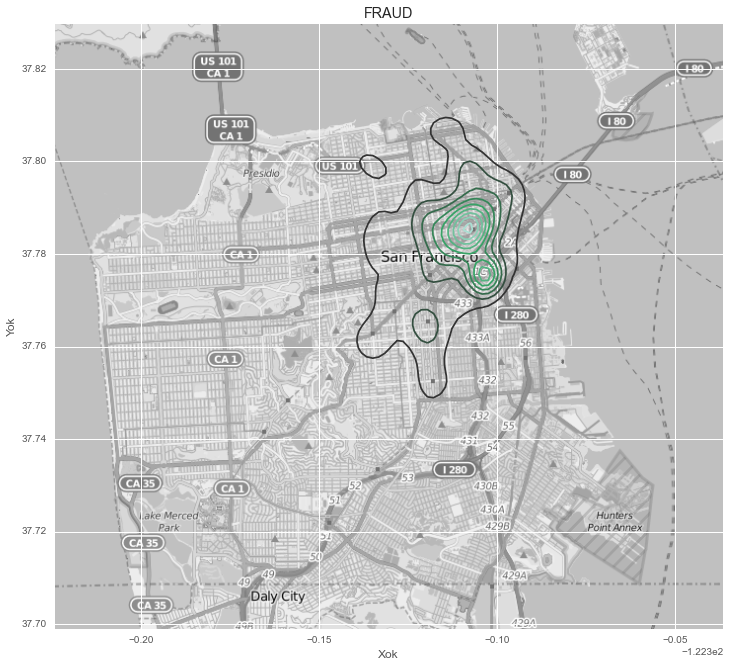

In [49]:
plot_map(categories[13])

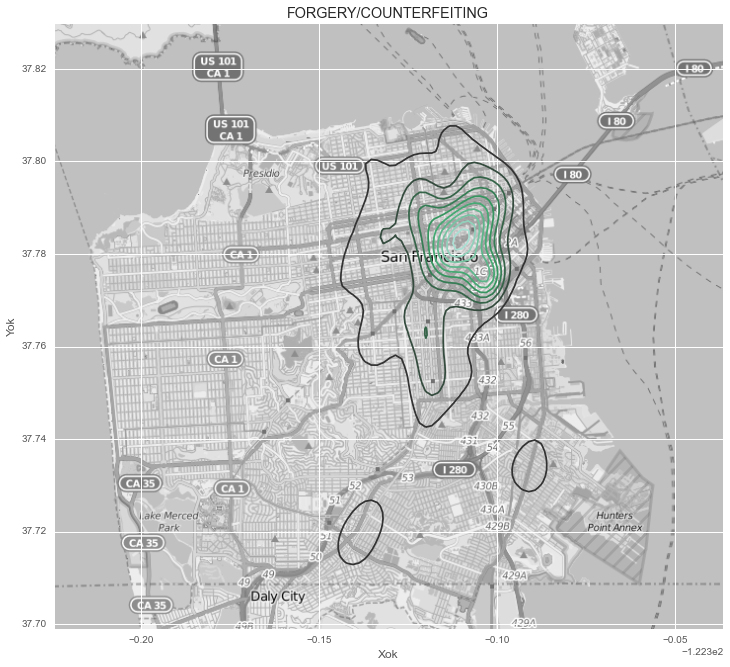

In [50]:
plot_map(categories[14])

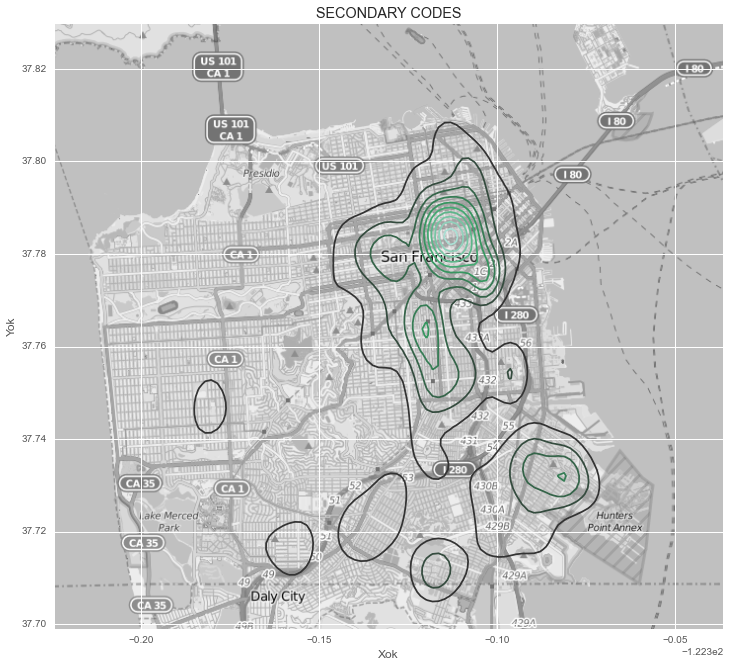

In [51]:
plot_map(categories[15])

## Classification

In [9]:
train.iloc[:1]

Dates  Category        Descript  DayOfWeek PdDistrict  \
0  2015-05-13 23:53:00  WARRANTS  WARRANT ARREST  Wednesday   NORTHERN   

       Resolution             Address           X          Y  
0  ARREST, BOOKED  OAK ST / LAGUNA ST -122.425892  37.774599

In [10]:
#Adresses modification

addresses = pd.DataFrame(train['Address'].value_counts(),columns = ['Count'])
addresses = addresses[addresses['Count'] > 500]

In [11]:
'''train['year_month'] = [x[:7] for x in train['Dates']]
train['full_hour'] = [x[11:16] for x in train['Dates']]'''


def text_conversion(datas):
    text_values = list(datas.value_counts().index)
    return [text_values.index(x) for x in datas]

def norm(datas,n = 1,v = 1):
    maximum = float(max(datas))
    if v == 1:
        normalized_datas = [n*float(x)/maximum for x in datas]
    else:
        normalized_datas = [float(x) for x in datas]
    return normalized_datas

def time_conversion(Date):
    year = float(Date[:4])-2000
    month = float(Date[5:7])
    day = float(Date[8:10])
    days = year*365+month*30+day
    return days

def address_conversion(address):
    if address in list(addresses.index):
        return address
    else:
        return 'other'

def treatment(dataset):
    datas = pd.DataFrame()
    datas['X'] = norm([abs(x) for x in dataset['X']],30)
    datas['Y'] = norm([abs(x) for x in dataset['Y']],30)
    #datas['year'] = norm([x[:4] for x in dataset['Dates']],1)
    #datas['month'] = norm([x[5:7] for x in dataset['Dates']],2)
    #datas['day'] = norm([x[8:10] for x in dataset['Dates']],0.5)
    datas['hour'] = norm([x[11:13] for x in dataset['Dates']],2)
    datas['PdDistrict'] = norm(text_conversion(dataset['PdDistrict']),4)
    #datas['DayOfWeek'] = norm(text_conversion(dataset['DayOfWeek']),3)
    datas['time'] = norm([time_conversion(x) for x in dataset['Dates']],2)
    datas['Address'] = [address_conversion(x) for x in dataset['Address']]
    datas['Address'] = norm(text_conversion(datas['Address']),15)
    return datas


In [12]:
train_datas = treatment(train.drop('Category',1))
train_targets = train['Category']
test_datas = treatment(test)

ZeroDivisionError: float division by zero

In [ ]:
train_datas.head()

In [69]:
from sklearn.cross_validation import train_test_split
datas1,datas2,targets1,targets2 = train_test_split(train_datas,train_targets,test_size = 0.4,random_state = None)

In [70]:
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#CLASSIFIER
classifiers = {
    1:naive_bayes.MultinomialNB(fit_prior = True),
    2:naive_bayes.GaussianNB(),
    3:LogisticRegression(),
    4:LinearSVC(C=1.0),
    5:RandomForestClassifier(n_estimators=5,min_samples_leaf = 15,min_samples_split = 5),
    6:GradientBoostingClassifier(random_state=1, n_estimators=5, max_depth=3),
    7:KNeighborsClassifier(),
    8:SVC(gamma=2, C=1),
    9:DecisionTreeClassifier(max_depth=5),
}


clf = classifiers[5]

#### Find and improve the features

X
Y
year
month
day
hour
PdDistrict
DayOfWeek
[0.25744547577017252, 0.26786914184841409, 0.19932520927054267, 0.19932520927054267, 0.19932520927054267, 0.20187631683844884, 0.22092990148624794, 0.19932520927054267]


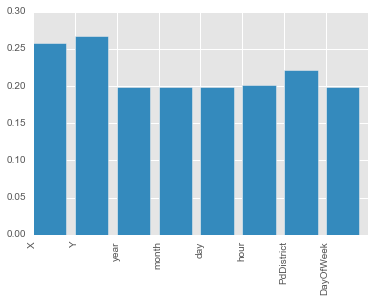

In [88]:
from sklearn.feature_selection import SelectKBest, f_classif

predictors = list(train_datas.columns)
scores = []

for predictor in predictors:
    print(predictor)
    clf.fit(datas1[[predictor]], targets1)
    scores += [clf.score(datas2[[predictor]],targets2)]

print(scores)

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

#### Prediction

In [75]:
#clf.fit(train_datas,train_targets)
clf.fit(datas1,targets1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=15, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [76]:
#test_targets = pd.DataFrame(clf.predict(test_datas),columns = ['targets'])
test_targets = pd.DataFrame(clf.predict(datas2),columns = ['targets'])

In [77]:
clf.score(datas2,targets2)

0.27854051591595014

In [78]:
cross = pd.crosstab(test_targets.targets,targets2)

def precision(category,cross):
    if category in list(cross.index):
        return cross.loc[category,category]/sum(cross[category])
    else:
        return 0
    
precisions = pd.DataFrame(index = cross.columns)
precisions['precision'] = [precision(category,cross) for category in cross.columns]
precisions.sort(['precision'],ascending = False).head()


precision
Category                 
LARCENY/THEFT    0.425195
OTHER OFFENSES   0.216716
NON-CRIMINAL     0.092699
DRUG/NARCOTIC    0.071054
ASSAULT          0.069842

***
### Submission

In [32]:
categories = sorted(list(train.Category.value_counts().index))
submission = pd.DataFrame(columns = categories)

for category in categories:
    submission[category] = test_targets.copy()
    submission[category][test_targets.targets == category] = 1
    submission[category][test_targets.targets != category] = 0

In [33]:
submission.to_csv('submission.csv')